<a href="https://colab.research.google.com/github/sanchitgulati/fluidSim/blob/main/fluidSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### [Inspiration](https://github.com/matthias-research/pages/blob/master/tenMinutePhysics/17-fluidSim.html)

In [85]:
import numpy as np
import math
from matplotlib import pyplot as plt

In [86]:
import time

In [87]:
overRelaxation = 1.9 # 1.9

In [88]:
from sklearn.preprocessing import normalize

In [89]:
U_FIELD = 0;
V_FIELD = 1;
S_FIELD = 2;

In [90]:
from matplotlib.pyplot import figure


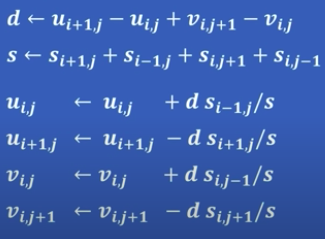

In [91]:
class Fluid:
    def __init__(self, density, numX, numY,gridSpacing):
        self.density = density
        self.numX = numX + 2 # Add Padding
        self.numY = numY + 2 # Add Padding 
        self.gridSpacing = gridSpacing
        self.v = np.empty((self.numY,self.numX), dtype=np.float32)
        self.u = np.empty((self.numY,self.numX), dtype=np.float32)
        self.p = np.empty((self.numY,self.numX), dtype=np.float32)
        self.s = np.empty((self.numY,self.numX), dtype=np.float32)
        self.m = np.empty((self.numY,self.numX), dtype=np.float32)
        self.m.fill(1.0)

    def simulate(self, dt, gravity, numIters):
        self.integrate(dt, gravity)
        self.p.fill(0.0)
        self.solveIncompressibility(numIters, dt)
        # self.extrapolate()
        # self.advectVel(dt)
        # self.advectSmoke(dt)

    def integrate(self, dt, gravity):
        for y in range(1, self.numY):
          for x in range(1, self.numX-1):
            if self.s[y][x] != 0 and self.s[y-1][x] != 0:
                self.v[y][x] += gravity * dt


    # Guass Seidel Method
    def solveIncompressibility(self, numIters, dt):
        cp = self.density * self.gridSpacing / dt
        for iter in range(numIters):
          for y in range(1, self.numY-1):
            for x in range(1, self.numX-1):
                    if self.s[y][x] == 0.0:
                        continue
                    sx0 = self.s[y][x-1] 
                    sx1 = self.s[y][x+1] 
                    sy0 = self.s[y-1][x] 
                    sy1 = self.s[y+1][x]
                    s = sx0 + sx1 + sy0 + sy1 # total
                    divergence = self.u[y][x+1] - self.u[y][x] + self.v[y+1][x]  - self.v[y][x]
                    p = -divergence / s
                    p *= overRelaxation
                    self.p[y][x] += cp * p

                    self.u[y][x] -= sx0 * p
                    self.u[y][x+1] += sx1 * p

                    self.v[y][x] -= sy0 * p
                    self.v[y+1][x] += sy1 * p

    def extrapolate(self):
        for y in range(self.numY):
            self.v[y][0] = self.v[y][1]
            self.v[y][self.numY - 1] = self.v[y][self.numY - 2]
        for x in range(self.numX):
            self.u[0][x] = self.u[1][x]
            self.u[self.numY - 1][x] = self.u[self.numY - 2][x]

    def sampleField(self, x, y, field):
        h = self.gridSpacing
        h1 = 1.0 / h
        h2 = 0.5 * h

        x = max(min(x, self.numX * h), h)
        y = max(min(y, self.numY * h), h)

        dx = 0.0
        dy = 0.0

        f = None

        if field == U_FIELD:
            f = self.u
            dy = h2
        elif field == V_FIELD:
            f = self.v
            dx = h2
        elif field == S_FIELD:
            f = self.m
            dx = h2
            dy = h2

        x0 = min(math.floor((x - dx) * h1), self.numX - 1)
        tx = ((x - dx) - x0 * h) * h1
        x1 = min(x0 + 1, self.numX - 1)

        y0 = min(math.floor((y - dy) * h1), self.numY - 1)
        ty = ((y - dy) - y0 * h) * h1
        y1 = min(y0 + 1, self.numY - 1)
        sx = 1.0 - tx
        sy = 1.0 - ty

        val = sx * sy * f[y0][x0]+ tx*sy * f[y0][x1]+ tx*ty * f[y1][x1]+ sx * ty * f[y1][x0]
        return val

    def avgU(self, x, y):
      return (self.u[y][x-1] + self.u[y][x]  + self.u[y+1][x-1] + self.u[y+1][x]) * 0.25

    def avgV(self, x, y):
      return (self.v[y-1][x] + self.v[y][x]  + self.v[y-1][x+1] + self.v[y][x+1]) * 0.25

    #Semi - Langrangian
    def advectVel(self, dt):
        self.newV = self.v.copy()
        self.newU = self.u.copy()

        n = self.numY
        h = self.gridSpacing
        h2 = 0.5 * h

        for y in range(1, self.numY-1):
            for x in range(1, self.numX-1):
                # u component
                if (self.s[y][x] != 0.0 and self.s[y-1][x] != 0.0):
                    yy = y * h
                    xx = x * h + h2
                    u = self.u[y][x]
                    v = self.avgV(x,y)
                    xx = xx - dt * u
                    yy = yy - dt * v
                    u = self.sampleField(xx, yy, U_FIELD)
                    self.newU[y][x] = u
                # v component
                if (self.s[y][x] != 0.0 and self.s[y][x-1] != 0.0):
                    yy = y*h + h2
                    xx = x * h
                    u = self.avgU(x,y)
                    v = self.v[y][x]
                    xx = xx - dt * u
                    yy = yy - dt * v
                    v = self.sampleField(xx, yy, V_FIELD)
                    self.newV[y][x] = v

        self.v = self.newV.copy()
        self.u = self.newU.copy()

    def advectSmoke(self, dt):
        self.newM = self.m.copy()
        h = self.gridSpacing
        h2 = 0.5 * h
        for y in range(1, self.numY - 1):
            for x in range(1, self.numX - 1):
                if self.s[y][x] != 0.0:
                    u = (self.v[y][x] + self.u[y+ 1][x]) * 0.5
                    v = (self.u[y][x] + self.v[y][x + 1]) * 0.5
                    xx = y* h + h2 - dt * u
                    yy = x * h + h2 - dt * v
                    self.newM[y][x] = self.sampleField(xx, yy, S_FIELD)

        self.m = self.newM.copy()


In [92]:
def setObstacle(f,obstacleRadius,simStep,posx, posy):
  for y in range(1, f.numY - 1):
      for x in range(1, f.numX - 1):
          f.s[y][x] = 1.0

          dx = (x + 0.5) * f.gridSpacing - posx
          dy = (y + 0.5) * f.gridSpacing - posy

          if dx * dx + dy * dy < obstacleRadius * obstacleRadius:
              f.s[y][x] = 0.0
              f.m[y][x] = 1 #+ 0.5 * math.sin(0.1 * simStep) # shake it ????
              f.u[y][x] = 0.0
              f.u[y+1][x] = 0.0
              f.v[y][x] = 0.0
              f.v[y][x+1] = 0.0


## Scene 1

In [93]:
# obstacleRadius = 0.15
# overRelaxation = 1.9
# dt = 1.0 / 60.0
# numIters = 1
# h = 0.01
# numX = 150
# numY = 100

# density = 1000.0

# f = Fluid(density, numX, numY, h)
# f.s.fill(1)
# f.p.fill(0)
# f.u.fill(0)
# f.v.fill(0)

# f.s[0, :] = 0  # bottom row
# # f.s[-1, :] = 0  # top row
# f.s[:, 0] = 0  # left column
# f.s[:, -1] = 0  # right column

# # f.s[1, :] = 0  # top row
# # f.s[-2, :] = 0  # bottom row
# # f.s[:, 1] = 0  # left column
# # f.s[:, -2] = 0  # right column

# plt.imshow(f.s, interpolation='nearest',origin='lower')
# plt.show()
# gravity = -9.81
# showPressure = True


In [94]:
# for step in range(100):
#   if(step%10 == 0):
#     minP = np.min(f.p)
#     maxP = np.max(f.p)
#     plt.title("minP {} N/m2 \nmaxP {} N/m2".format(minP,maxP))
#     plt.imshow(f.v, cmap = 'viridis',origin='lower')
#     plt.show()
#   # program_starts = time.time()
#   f.simulate(dt,gravity,numIters)
#   # now = time.time()
#   # print("It has been {:.2f} seconds since the iter {} started".format(now - program_starts,step))

## End

# Scene 2

In [95]:
obstacleRadius = 0.1
overRelaxation = 1.9
dt = 1.0 / 120.0

res = 100

numX = 150
numY = 100
gridSpacing = 0.001
density = 1000.0


inVel = 2.0
f = Fluid(density=density, numX=numX,numY=numY,  gridSpacing=gridSpacing)
f.s.fill(1)
f.p.fill(0)
f.u.fill(0)
f.v.fill(0)
f.m.fill(1)
f.s[0, :] = 0  # top wall
f.s[-1, :] = 0  # bottom wall
# f.s[:, 0] = 0  # left wall
f.s[:, -1] = 0  # right wall

f.u[:, 0:3] = 2.0  # left wall In vel

gravity = -9.81
showPressure = True


pipeH = 0.1 * f.numY
minx = int(0.5 * f.numY - 0.5 * pipeH)
maxx = int(0.5 * f.numY + 0.5 * pipeH)

obstacleX = 0.5
obstacleY = 0.5

for y in range(minx, maxx):
    f.m[y,0] = 0.0
    
setObstacle(f,obstacleRadius=obstacleRadius,simStep=0,posx=obstacleX ,posy=obstacleY)
gravity = -9.8


In [96]:
# %%time
# Steps = 100
# # Create a Position index
# for step in range(Steps):
#   if(step%10 == 0):
#     plt.title("Step {}".format(step))
#     plt.imshow(normalize(f.u),vmin=0,vmax=1,animated=True,cmap = 'viridis', interpolation='nearest',origin='lower')
#     plt.show()
#   f.simulate(dt,gravity,numIters)